In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [6]:

# Load dataset
train_df = pd.read_csv("C:/Users/HP/Downloads/train (1).csv")
test_df = pd.read_csv('C:/Users/HP/Downloads/test (1).csv')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            164 non-null    int64  
 1   symboling         164 non-null    int64  
 2   CarName           164 non-null    object 
 3   fueltype          164 non-null    object 
 4   aspiration        164 non-null    object 
 5   doornumber        164 non-null    object 
 6   carbody           164 non-null    object 
 7   drivewheel        164 non-null    object 
 8   enginelocation    164 non-null    object 
 9   wheelbase         164 non-null    float64
 10  carlength         164 non-null    float64
 11  carwidth          164 non-null    float64
 12  carheight         164 non-null    float64
 13  curbweight        164 non-null    int64  
 14  enginetype        164 non-null    object 
 15  cylindernumber    164 non-null    object 
 16  enginesize        164 non-null    int64  
 1

In [11]:
train_df.head(10)

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,0,mazda rx-7 gs,diesel,std,four,sedan,rwd,front,104.9,175.0,...,134,idi,3.43,3.64,22.0,72,4200,31,39,18344.0
1,0,peugeot 504,gas,std,four,sedan,rwd,front,107.9,186.7,...,120,mpfi,3.46,2.19,8.4,95,5000,19,24,15580.0
2,0,toyota corona hardtop,gas,std,four,wagon,fwd,front,95.7,169.7,...,92,2bbl,3.05,3.03,9.0,62,4800,31,37,6918.0
3,1,nissan latio,gas,std,four,sedan,fwd,front,94.5,165.3,...,97,2bbl,3.15,3.29,9.4,69,5200,31,37,7499.0
4,0,honda civic 1300,gas,std,two,hatchback,fwd,front,96.5,167.5,...,110,1bbl,3.15,3.58,9.0,86,5800,27,33,9095.0
5,1,dodge monaco (sw),gas,std,four,hatchback,fwd,front,93.7,157.3,...,90,2bbl,2.97,3.23,9.4,68,5500,31,38,6229.0
6,2,subaru dl,gas,std,two,hatchback,fwd,front,93.7,157.9,...,108,2bbl,3.62,2.64,8.7,73,4400,26,31,7053.0
7,0,peugeot 604sl,diesel,turbo,four,sedan,rwd,front,107.9,186.7,...,152,idi,3.70,3.52,21.0,95,4150,28,33,16900.0
8,3,dodge coronet custom (sw),gas,turbo,two,hatchback,fwd,front,95.9,173.2,...,156,mfi,3.60,3.90,7.0,145,5000,19,24,12964.0
9,1,chevrolet monte carlo,gas,std,two,hatchback,fwd,front,94.5,155.9,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,6295.0


In [15]:

# 1. Drop irrelevant columns to avoid overfitting
train_df = train_df.drop(columns=['CarName', 'carbody', 'enginelocation', 'enginetype', 'fuelsystem'])

In [37]:

# 2. Feature engineering function
def custom_feature_engineering(X):
    X = X.copy()
    
    mapping = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12}
    
    if 'doornumber' in X.columns:
        X['doornumber'] = X['doornumber'].map(mapping)
        
    if 'cylindernumber' in X.columns:
        X['cylindernumber'] = X['cylindernumber'].map(mapping)
    
    return X

feature_engineering = FunctionTransformer(custom_feature_engineering)

In [38]:
# 3. Define column types
categorical_cols = ['symboling','fueltype', 'aspiration', 'drivewheel','doornumber', 'cylindernumber']
numeric_cols = ['wheelbase', 'enginesize', 'boreratio', 'stroke',
                'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']

# 4. Pipelines for preprocessing
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, categorical_cols),
    ('num', num_pipeline, numeric_cols)
])

# 5. Full pipeline with Ridge regression
full_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

# 6. Split data
X = train_df.drop('price', axis=1)
y = np.log1p(train_df['price'])  # log(1 + price) why ? incase the price is too large 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train model
full_pipeline.fit(X_train, y_train)

# 8. Predict and evaluate
y_pred = full_pipeline.predict(X_test)

# Inverse transform predictions and true labels
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)

# Evaluation
print("R² score:", r2_score(y_test_exp, y_pred_exp))
print("MAE:", mean_absolute_error(y_test_exp, y_pred_exp))
print("RMSE:", np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))


R² score: 0.871979390848445
MAE: 1490.7781952932512
RMSE: 2349.343506599588


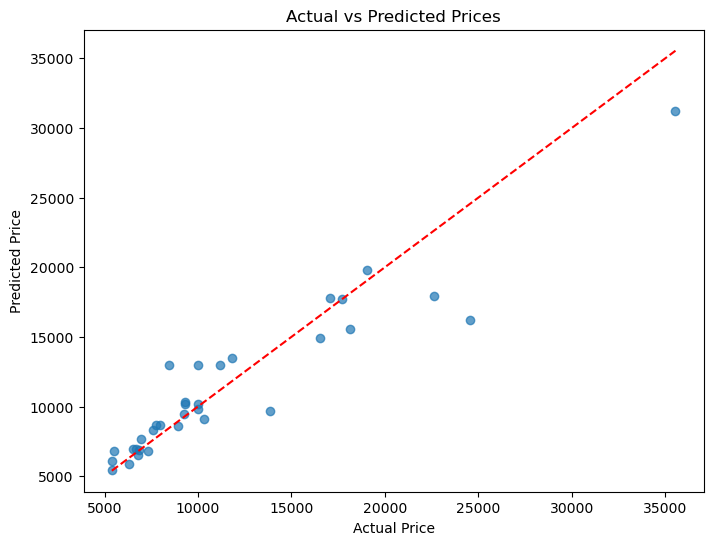

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.7)
plt.plot([y_test_exp.min(), y_test_exp.max()],
         [y_test_exp.min(), y_test_exp.max()],
         'r--')  # diagonal line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

In [36]:
from sklearn import set_config
set_config(display='diagram')  # Nice diagram of your pipeline
full_pipeline


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function custom_feature_engineering at 0x00000254C1F5E7A0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fueltype', 'aspiration',
                                                   'drivewheel', 'doornumber',
                                                   'cylindernumber']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['wheelbase', 'enginesize',
                                                   'boreratio', 'stroke',
                                                   'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg',
                                                   'highwaympg'])])),
                ('model', Ridge())])

In [23]:
param_grid = {
    'model__alpha': [.001,0.01, 0.1, 1, 10, 100]
}

# 4. Grid search with CV
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 5. Evaluation
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
val_preds = grid_search.predict(X_test)
print(f"Validation R²: {r2_score(y_test, val_preds):.4f}")


Best Params: {'model__alpha': 10}
Best CV Score: 0.8416
Validation R²: 0.8677


In [35]:
X.head()

,symboling,fueltype,aspiration,doornumber,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,0,diesel,std,four,rwd,104.9,175.0,66.1,54.4,2700,four,134,3.43,3.64,22.0,72,4200,31,39
1,0,gas,std,four,rwd,107.9,186.7,68.4,56.7,3075,four,120,3.46,2.19,8.4,95,5000,19,24
2,0,gas,std,four,fwd,95.7,169.7,63.6,59.1,2280,four,92,3.05,3.03,9.0,62,4800,31,37
3,1,gas,std,four,fwd,94.5,165.3,63.8,54.5,1971,four,97,3.15,3.29,9.4,69,5200,31,37
4,0,gas,std,two,fwd,96.5,167.5,65.2,53.3,2289,four,110,3.15,3.58,9.0,86,5800,27,33


In [41]:

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('feature_engineering', feature_engineering),
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = np.expm1(pipeline.predict(X_test))
    print(f"\nModel: {name}")
    print("R²:", r2_score(y_test_exp, y_pred))
    print("MAE:", mean_absolute_error(y_test_exp, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_exp, y_pred)))



Model: LinearRegression
R²: 0.8719070864245657
MAE: 1358.2286502495422
RMSE: 2350.0068527272942

Model: Ridge
R²: 0.871979390848445
MAE: 1490.7781952932512
RMSE: 2349.343506599588

Model: RandomForest
R²: 0.8838947825384812
MAE: 1547.917193984635
RMSE: 2237.3423571760395

Model: SVR
R²: 0.864807191745123
MAE: 1629.0981260108126
RMSE: 2414.2562886420237


In [46]:
test_df = pd.read_csv('C:/Users/HP/Downloads/test (1).csv')
test_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,16,0,bmw x4,gas,std,four,sedan,rwd,front,103.5,...,six,209,mpfi,3.62,3.39,8.00,182,5400,16,22
1,10,0,audi 5000s (diesel),gas,turbo,two,hatchback,4wd,front,99.5,...,five,131,mpfi,3.13,3.40,7.00,160,5500,16,22
2,101,0,nissan nv200,gas,std,four,sedan,fwd,front,97.2,...,four,120,2bbl,3.33,3.47,8.50,97,5200,27,34
3,133,3,saab 99e,gas,std,two,hatchback,fwd,front,99.1,...,four,121,mpfi,3.54,3.07,9.31,110,5250,21,28
4,69,-1,buick century luxus (sw),diesel,turbo,four,wagon,rwd,front,110.0,...,five,183,idi,3.58,3.64,21.50,123,4350,22,25


In [49]:


# # 8. Prepare the submission file

# Save car_IDs before dropping the column
car_ids = test_df['car_ID'].copy()

# Predict prices on the test data
test_predictions =  np.expm1(pipeline.predict(test_df))

# # Create the submission DataFrame with original car_IDs and predicted prices
submission = pd.DataFrame({
    'car_ID': car_ids,  # Assuming car_ID starts from 1
    'PredictedPrice': test_predictions
})

# # Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
